In [1]:
%matplotlib inline

from io import BytesIO
from base64 import b64encode

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from PIL import Image

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [2]:
infd = open('he010-cbar.tbc', 'rb')

indata = infd.read()

data = np.fromstring(indata, 'uint16', len(indata)//2)

In [3]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 844, y = 505, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
#drawdata(data)                         

In [4]:
# This follows the default scale in lddecodercuda
minire = -60
maxire = 140

hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)

out_scale = 65534.0 / (maxire - minire)

in_scale = out_scale
in_minire = -60

def RawToIRE(data):
    return (np.float32(data) / in_scale) + in_minire

def IREToRaw(data):
    return np.uint16((data - minire) * out_scale)

In [45]:
rowphase = data[:505*844].reshape(505,844)[:,0] == 32768
data1 = RawToIRE(data[:505*844])


#drawdata(data1)

In [46]:
data1

array([-59.5696907 ,  90.00457764, -59.5696907 , ...,  -0.73916245,
        -0.11353302,  -1.27628708], dtype=float32)

In [47]:
import tensorflow as tf


In [48]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.2)
#with tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options)) as sess:
    #print('hi!')

In [49]:
session = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x7ff2a5c8ab70>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 522, in __del__
    self.close()
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py", line 1262, in close
    self._default_session.__exit__(None, None, None)
  File "/usr/lib/python3.5/contextlib.py", line 66, in __exit__
    next(self.gen)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3536, in get_controller
    % type(default))
AssertionError: Nesting violated for default stack of <class 'weakref'> objects


In [50]:
data1.shape

(426220,)

In [51]:
ntscimg_shape = [1, 505, 844, 1]

# Create I and Q mask images

IQmask_p = np.zeros((505, 844), dtype=np.float32)

for i in range(0, 844, 4):
    # We can transpose the array and set all values of a column at once
    IQmask_p.T[i + 0] = 1
    IQmask_p.T[i + 1] = -1
    IQmask_p.T[i + 2] = -1
    IQmask_p.T[i + 3] = 1
    
IQmask = tf.Variable(IQmask_p.reshape(ntscimg_shape), dtype=tf.float32)
IQmask.initializer.run()

partIQp = np.zeros((844), dtype=np.int32)

for i in range(0, 844, 2):
    # We can transpose the array and set all values of a column at once
    partIQp[i] = 0
    partIQp[i + 1] = 1
    
partIQ = tf.Variable(partIQp.reshape([1, 844]), dtype=tf.int32)
partIQ.initializer.run()

stitchIQ = []
for i in [0, 1]:
    stitchp = np.where(partIQp == i)[0]

    stitchIQ.append(tf.Variable(stitchp.reshape([1, 422]), dtype=tf.int32))
    stitchIQ[-1].initializer.run()

In [52]:
ntscimg_shape = [1, 505, 844, 1]

x = tf.placeholder(tf.float32, ntscimg_shape)
partition = tf.placeholder(tf.int32, [1, 505])
stitches1 = tf.placeholder(tf.int32)
stitches2 = tf.placeholder(tf.int32)

phaseinvert = tf.Variable(np.full((505, 844),-1,dtype=np.float32).reshape(ntscimg_shape), dtype=tf.float32)
phaseinvert.initializer.run()

# create color data
YC_convolve = tf.Variable(np.array([0.5, -1, 0.5]).reshape(1, 3, 1, 1), dtype=tf.float32)
YC_convolve.initializer.run()

c = tf.nn.conv2d(x, YC_convolve, strides=[1, 1, 1, 1], padding="SAME")

# fix phase and levels
csplit = tf.dynamic_partition(c, partition, 2)
csplit[1] *= -1 
c_fixedphase = tf.reshape(tf.dynamic_stitch([stitches1, stitches2], csplit), ntscimg_shape)
c_fixedlevels = c_fixedphase * IQmask

# break out I and Q - note that horizontal splits/joins seem to require transposition!

c_fixedlevelsT = tf.transpose(c_fixedlevels)

partedIQ = tf.dynamic_partition(c_fixedlevelsT, partIQ, 2)
I = tf.reshape(tf.transpose(partedIQ[0]), [1, 505, 422, 1])
Q = tf.reshape(tf.transpose(partedIQ[1]), [1, 505, 422, 1])

# Processing goes here



# Combine I and Q back together
IQs = tf.dynamic_stitch([stitchIQ[0], stitchIQ[1]], [tf.transpose(I), tf.transpose(Q)])

C_afterproc = tf.reshape(tf.transpose(IQs), ntscimg_shape) * IQmask

# re-invert phase and levels for YC sep

csplit2 = tf.dynamic_partition(C_afterproc, partition, 2)
csplit2[1] *= -1 
c_fory0 = tf.dynamic_stitch([stitches1, stitches2], csplit2)
c_fory = tf.reshape(c_fory0, ntscimg_shape)

y = x + c_fory

# Double I and Q width - reuse I+Q rejoining system with I and Q repeated
Iwide_pre = tf.dynamic_stitch([stitchIQ[0], stitchIQ[1]], [tf.transpose(I), tf.transpose(I)])
Iwide = tf.reshape(tf.transpose(Iwide_pre), ntscimg_shape)

Qwide_pre = tf.dynamic_stitch([stitchIQ[0], stitchIQ[1]], [tf.transpose(Q), tf.transpose(Q)])
Qwide = tf.reshape(tf.transpose(Qwide_pre), ntscimg_shape)



In [53]:
np.min(data1)

-60.0

In [58]:
in_partition = np.int32(rowphase).reshape(1,505)
in_stitches1 = np.where(in_partition == 0)[1]
in_stitches2 = np.where(in_partition == 1)[1]

output = session.run([y, Iwide, Qwide, I, Q], feed_dict={x: data1.T.reshape(1,505,844,1), 
                                                      partition: in_partition,
                                                      stitches1: in_stitches1,
                                                      stitches2: in_stitches2})

In [59]:
np.max(output[0]) / 65536

0.0016005871584638953

(426220,)
uint8 (505, 844) (505, 844)


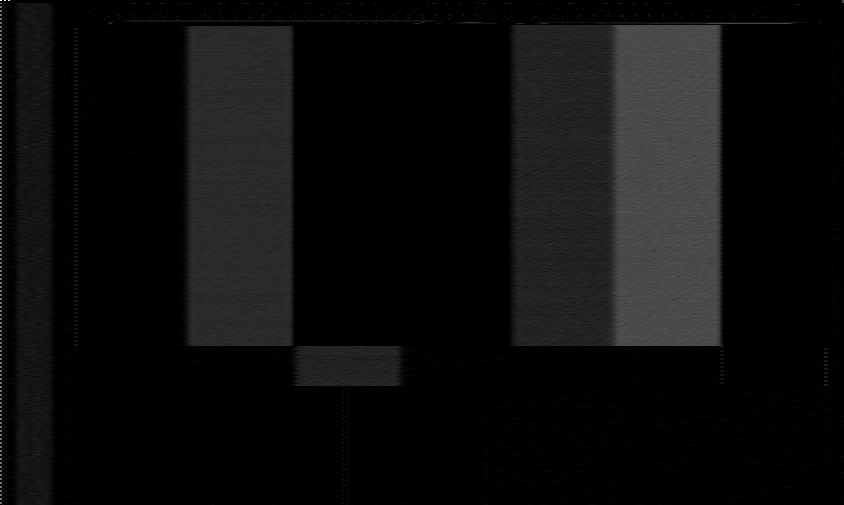

In [60]:
o = 2
I_out = output[o].reshape(output[o].shape[1] * output[o].shape[2])

drawdata(np.clip(I_out, 0.0, 100.0) * 655, output[o].shape[2], output[o].shape[1])
#drawdata(data_out, 844, output[-1].shape[1])

In [61]:
output[0].shape

(1, 505, 844, 1)

In [62]:
y = output[0].reshape((505, 844))
q = output[1].reshape((505, 844))
i = output[2].reshape((505, 844))

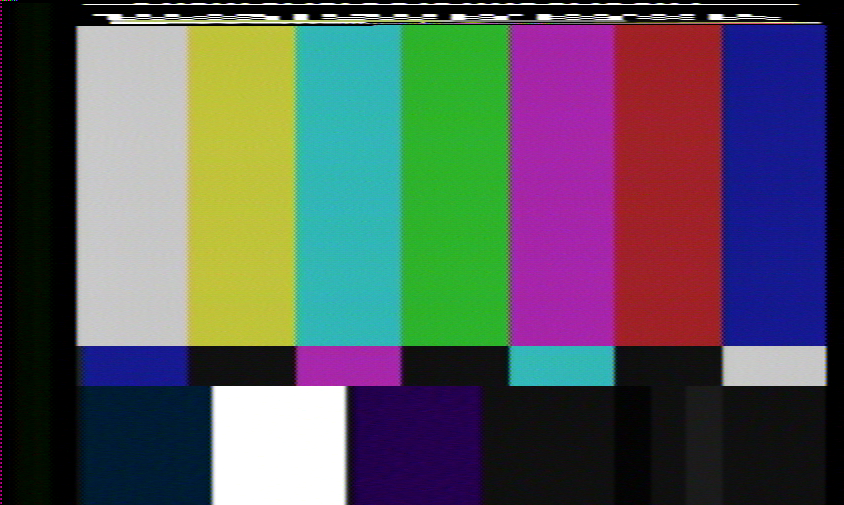

In [63]:
r = y + (.956 * i) + (.621 * q)
g = y - (.272 * i) - (.647 * q)
b = y - (1.106 * i) + (1.703 * q)

rgbArray = np.zeros((505,844,3), 'uint8')
rgbArray[...,0] = np.clip(r, 0, 100) * 2.55
rgbArray[...,1] = np.clip(g, 0, 100) * 2.55
rgbArray[...,2] = np.clip(b, 0, 100) * 2.55

im = Image.fromarray(rgbArray)
im = im.resize((844, 505))

#    imshow(np.asarray(im))

b = BytesIO()
im.save(b, format='png')
IPython.display.Image(b.getvalue())

<h3>Layer structure</h3>

- There are two possible line phases, which need different convolutions to get
  the correct color values.  Each frame inverts phases... but pause mode and 
  scanning/skipping can disrupt that.  So we should probably check an area of each 
  frame to be safe.
  
  (could also look at each color burst, but that kinda sequential code is horrible in
  Python and I doubt it can be worked into the graph.)



- 4FSC provides mathematical advantages.  Each pixel is a unique I/Q phase...

p0 +I, p1 -Q, p2 -I, p3 +Q

- In comb-ntsc.cxx 1 and 2 are inverted to enable color level filtering and inverted for IQ values.  For this version should we split it into 2 422-row pictures and apply filters that way, then stitch back into 844?



Possible chain:

- YC convolution (switchable masks for each field type)


- splitting on IQ (dynamic partition)
- I Q filtering
- (2D corrections?)


- desplitting (tf.dynamic_stitch)
- remove C from Y 
